# Unbinned Profiled Unfolding

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate simulation and data events from Gaussian distribution

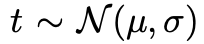

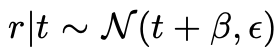

In [2]:
Ndata = 1000
Nsim = 1000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

In [3]:
bins = np.linspace(-3,3,10)

Define w0 (parameters: sigma, mu (correspond to simulation), a, b (correspond to data)), 

and w1 (parameters: epsilon, beta (correspond to simulation), c, d (correspond to data))
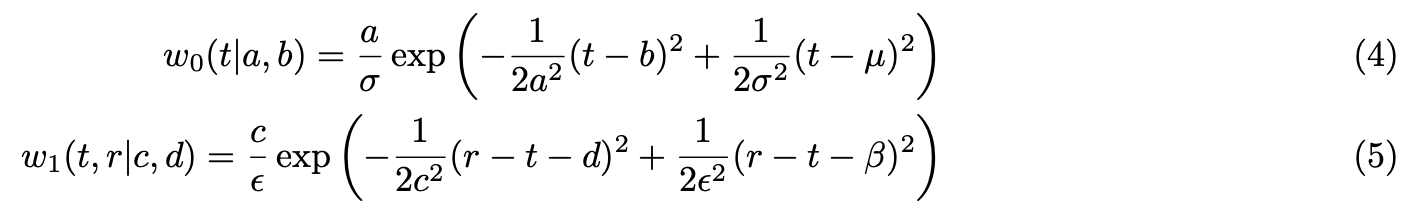

In [4]:
def gauss_ratio(x,sigma,mu,a,b):
    return (a/sigma)*np.exp(-0.5*(x-b)**2/a**2+0.5*(x-mu)**2/sigma**2)

def w0(t,sigma,mu,a,b):
    return gauss_ratio(t,sigma,mu,a,b)

def w1(r,t,epsilon,beta,c,d):
    return gauss_ratio(r,epsilon,t+beta,c,t+d)

def log_gauss(x,sigma,mu):
    return -0.5*(x-mu)**2/sigma**2

Scan through b and c and fix all the other parameters

Calculate likelihood scan

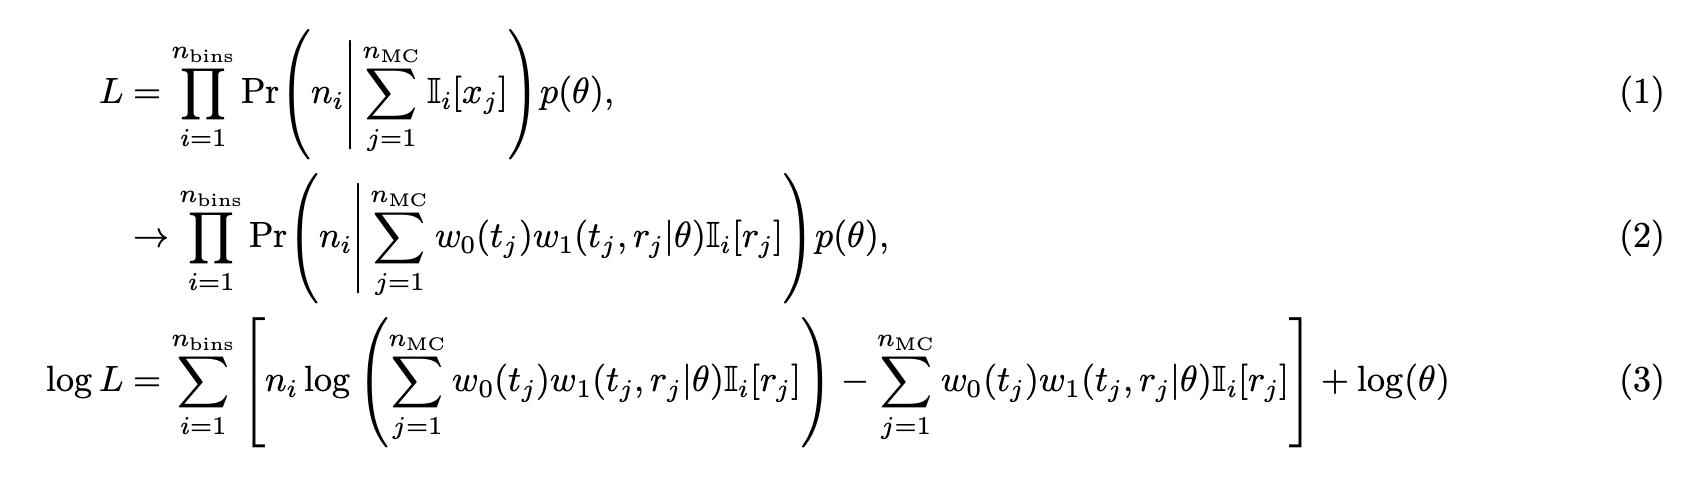

In [5]:
lls = []
for test_mu in np.linspace(-0.5,0.5,50):
    #print(test_mu)
    lls += [[]]
    for test_epsilon in np.linspace(0.8,1.2,50):
        per_bin = 0
        for i in range(len(bins)):
            mysum = np.sum((np.digitize(R_sim,bins)==i)*w0(T_sim,sigma_sim,mu_sim,1,test_mu)*w1(R_sim,T_sim,epsilon_sim,beta_sim,test_epsilon,0))
            ni = np.sum((np.digitize(R_data,bins)==i))
            if (mysum > 0):
                per_bin+=ni*np.log(mysum) - mysum + log_gauss(test_epsilon,epsilon_sim*0.1,epsilon_sim)
            pass
        lls[-1] += [per_bin]

Text(0.5, 1.0, 'Log Likelihood')

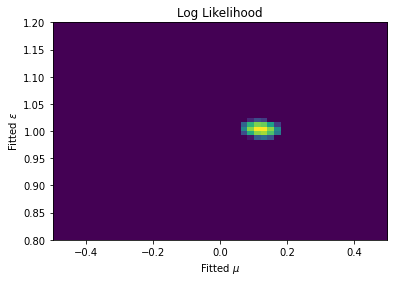

In [6]:
extent = -0.5, 0.5,0.8, 1.2
lls = np.array(lls)
plt.imshow(lls.T, extent=extent, aspect='auto', vmin = np.max(lls)-1, vmax = np.max(lls))
plt.xlabel("Fitted $\mu$")
plt.ylabel("Fitted $\epsilon$")
plt.title("Log Likelihood")

## Now try to solve the problem with deep learning!

In [7]:
%load_ext tensorboard
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


In [8]:
Ndata = 1000
Nsim = 100000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

epsilon_sim_theta_for_parametrization = np.random.uniform(0.5, 1.5, Nsim)
epsilon_sim_theta = np.random.uniform(0.5, 1.5, Nsim)
R_sim_theta = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    R_sim_theta.append(np.random.normal(T_sim[i]+beta_sim,epsilon_sim_theta[i]))
R_sim_theta = np.array(R_sim_theta)

T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

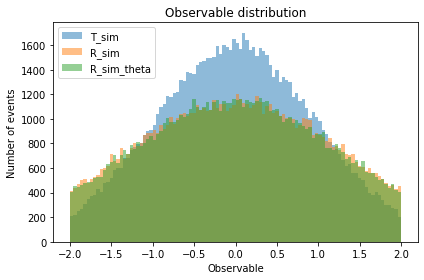

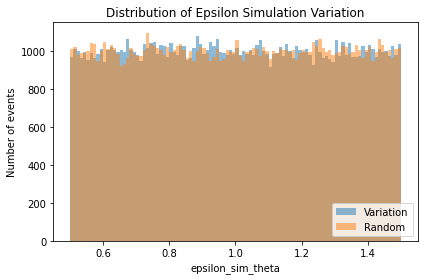

In [9]:
plt.hist(T_sim, range=(-2, 2), density=False, bins=100, label="T_sim", alpha=0.5)
plt.hist(R_sim, range=(-2, 2), density=False, bins=100, label="R_sim", alpha=0.5)
plt.hist(R_sim_theta, range=(-2, 2), density=False, bins=100, label="R_sim_theta", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilon_sim_theta, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.hist(epsilon_sim_theta_for_parametrization, range=(0.5, 1.5), density=False, bins=100, label="Random", alpha=0.5)
plt.xlabel('epsilon_sim_theta')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [10]:
class w1_dataset(Dataset):
    def __init__(self, T_sim, R_sim, R_sim_theta, epsilon_sim_theta_for_parametrization, epsilon_sim_theta):
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.inds = np.random.randint(0,len(R_sim_theta),len(R_sim))
        
    def __len__(self):
        return len(R_sim)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 0:
            data = torch.tensor([R_sim[i], epsilon_sim_theta_for_parametrization[i], T_sim[i], T_sim[self.inds[i]]]) # use the same T_sim for R_sim variation
        else:
            data = torch.tensor([R_sim_theta[self.inds[i]], epsilon_sim_theta_for_parametrization[i], T_sim[i], T_sim[self.inds[i]]])
        return data, label
    
# Do we standardize the input variables?

In [11]:
w1_ds = w1_dataset(T_sim, R_sim, R_sim_theta, epsilon_sim_theta_for_parametrization, epsilon_sim_theta)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=64, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=64, shuffle=False, num_workers=12)

In [12]:
batch = next(iter(w1_dataloader_train))
print(batch)

[tensor([[-1.5719e+00,  5.0273e-01, -1.1663e+00, -6.5319e-01],
        [-3.7193e+00,  1.1514e+00, -2.9458e-01, -1.3445e+00],
        [-1.2406e+00,  1.3461e+00,  4.2139e-01,  4.1684e-01],
        [-1.3635e+00,  8.3517e-01, -3.3858e-01, -1.2533e+00],
        [-1.5231e+00,  5.3278e-01, -3.9677e-01, -1.2122e+00],
        [ 1.3907e+00,  1.3305e+00, -9.1395e-01,  7.2103e-02],
        [-5.8689e-01,  1.0221e+00, -1.8293e-01,  8.1099e-01],
        [-1.0202e+00,  1.2503e+00,  8.3563e-01, -4.6517e-01],
        [-4.7201e-01,  1.3766e+00, -8.0747e-01,  1.5891e+00],
        [ 9.3327e-01,  9.4403e-01,  1.2151e+00,  9.1630e-01],
        [ 2.0349e+00,  1.3929e+00, -2.5621e-01,  1.0519e+00],
        [ 1.4565e+00,  6.7744e-01,  1.6555e+00, -2.6232e-02],
        [-4.5848e-01,  7.3898e-01, -3.8143e-01, -9.0893e-01],
        [ 7.6228e-01,  7.9504e-01, -1.4316e-01,  2.0726e-01],
        [ 2.7799e+00,  1.2339e+00, -3.0770e-01,  1.2205e+00],
        [-7.2323e-01,  9.4620e-01,  5.8475e-01, -1.5130e+00],
       

In [13]:
import sys, os

class w1(LightningModule):
    def __init__(self, device="cpu"):
        super(w1, self).__init__()
        self.dvc = device
        self.loss_fn = nn.BCELoss()
        self.epoch = 0
        
        # currently using the less constrained model
        self.linear_relu_stack = nn.Sequential()
        self.linear_relu_stack.add_module("linear_1", nn.Linear(4, 50))
        self.linear_relu_stack.add_module("relu_1", nn.ReLU())
        self.linear_relu_stack.add_module("linear_2", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_2", nn.ReLU())
        self.linear_relu_stack.add_module("linear_3", nn.Linear(50, 50))
        self.linear_relu_stack.add_module("relu_3", nn.ReLU())
        self.linear_relu_stack.add_module("linear_4", nn.Linear(50, 1))
        self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.dvc), y.to(self.dvc)
        logits = self(x)
        ls = self.loss_fn(logits, y.unsqueeze(1).double())
        return {"loss": ls, "score": logits.detach(), "target": y}

    def training_epoch_end(self, training_step_outputs):
        self.training_loss = 0
        scores, ys = None, None
        for training_step_output in training_step_outputs:
            self.training_loss += torch.mul(training_step_output["loss"], len(training_step_output["target"])).item()
            scores = torch.cat([scores, training_step_output["score"]]) if scores is not None else training_step_output["score"]
            ys = torch.cat([ys, training_step_output["target"]]) if ys is not None else training_step_output["target"]

        self.training_loss /= len(ys)

        scores = scores.cpu().numpy().reshape(-1)
#         ys = ys.cpu().numpy()

        self.log("train_loss", self.training_loss)

#         sys.stdout.write('\033[2K\033[1G')
#         sys.stdout.write(f'Epoch {self.epoch}: Train loss - {self.training_loss}, Val loss - {self.validation_loss}\n')
        print("\r"+" "*(os.get_terminal_size().columns-1), end="")
        print("\r"+f'Epoch {self.epoch}: Train loss - {self.training_loss}, Val loss - {self.validation_loss}')
        self.epoch += 1

    def validation_epoch_end(self, validation_step_outputs):
        self.validation_loss = 0
        scores, ys = None, None
        for validation_step_output in validation_step_outputs:
#             self.validation_loss += torch.mul(validation_step_output["loss"], len(validation_step_output["target"])).item()
            scores = torch.cat([scores, validation_step_output["score"]]) if scores is not None else validation_step_output["score"]
            ys = torch.cat([ys, validation_step_output["target"]]) if ys is not None else validation_step_output["target"]

#         self.validation_loss /= len(ys)
        self.validation_loss = self.loss_fn(scores, ys.unsqueeze(1).double())

        scores = scores.cpu().numpy().reshape(-1)
#         ys = ys.cpu().numpy()

        self.log("val_loss", self.validation_loss)

    def test_epoch_end(self, test_step_outputs):
        self.test_loss = 0
        scores, ys = None, None
        for test_step_output in test_step_outputs:
            # self.test_loss += torch.mul(test_step_output["loss"], len(test_step_output["target"])).item()
            scores = torch.cat([scores, test_step_output["score"]]) if scores is not None else test_step_output["score"]
            ys = torch.cat([ys, test_step_output["target"]]) if ys is not None else test_step_output["target"]

#         self.test_loss /= len(ys)
        self.test_loss = self.loss_fn(scores, ys.unsqueeze(1).double())

        self.test_scores = scores.cpu().numpy().reshape(-1)
#         self.test_ys = ys.cpu().numpy()

        self.log("test_loss", self.test_loss)

        # sys.stdout.write('Finished. \n')
        # sys.stdout.write(f'Test loss - {self.test_loss} \n')

    def configure_optimizers(self):
        return optim.Adam(self.parameters())

In [14]:
model_w1 = w1(device=dvc).double().to(dvc)
print(model_w1)

w1(
  (loss_fn): BCELoss()
  (linear_relu_stack): Sequential(
    (linear_1): Linear(in_features=4, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=50, bias=True)
    (relu_3): ReLU()
    (linear_4): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [15]:
from tqdm import tqdm
from pytorch_lightning.callbacks import ProgressBar

class LitProgressBar(ProgressBar):
   
    def init_validation_tqdm(self):
        bar = tqdm(            
            disable=True,            
        )
        return bar

bar = LitProgressBar()

callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, check_finite=True), bar]
callbacks.append(ModelCheckpoint(
    save_top_k=1,
    monitor='val_loss',
    mode='min',
    dirpath='model/w1',
    filename='best',
))

trainer = Trainer(accelerator=device, devices=1, callbacks=callbacks, default_root_dir='model/w1')

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/pytorch_lightning/callbacks/progress/progress.py:22: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  "`ProgressBar` has been deprecated in v1.5 and will be removed in v1.7."
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [16]:
trainer.fit(model_w1, w1_dataloader_train, w1_dataloader_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | loss_fn           | BCELoss    | 0     
1 | linear_relu_stack | Sequential | 5.4 K 
-------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /afs/cern.ch/work/c/cchan/UnbinnedProfiledUnfolding/model/w1 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Epoch 0: Train loss - 0.5484096476147632, Val loss - 0.5383585573480532                                                                                                                                                                 
Epoch 1: Train loss - 0.5395086600592843, Val loss - 0.538780108917065                                                                                                                                                                  
Epoch 2: Train loss - 0.5387784744036009, Val loss - 0.5387869562025018                                                                                                                                                                 
Epoch 3: Train loss - 0.5384102336305455, Val loss - 0.5397850491862823                                                                                                                                                                 
Epoch 4: Train loss - 0.5381995050145331, Val loss - 0.5372014778124

In [32]:
# !tensorboard --logdir .

In [57]:
Nsim = 100000

mu_sim_prime = 0
sigma_sim_prime = 1
beta_sim_prime = 0
epsilon_sim_0 = 1
epsilon_sim_prime = 1.5

T_sim_prime = np.random.normal(mu_sim_prime,sigma_sim_prime,Nsim)
R_sim_prime = np.random.normal(T_sim+beta_sim_prime,epsilon_sim_prime)
xprime = np.c_[R_sim_prime,np.ones(Nsim)*epsilon_sim_prime,T_sim_prime,T_sim_prime]
xprime = torch.from_numpy(xprime).to(dvc)

T_sim_0 = np.random.normal(mu_sim_prime,sigma_sim_prime,Nsim)
R_sim_0 = np.random.normal(T_sim_0+beta_sim_prime,epsilon_sim_0)
x0 = np.c_[R_sim_0,np.ones(Nsim)*epsilon_sim_prime,T_sim_0,T_sim_0]
x0 = torch.from_numpy(x0).to(dvc)

# load checkpoint
checkpoint = "model/w1/best.ckpt"
model_w1 = w1.load_from_checkpoint(checkpoint, device=dvc).double().to(dvc)
model_w1.eval()
scores = model_w1(x0).detach().cpu().numpy().reshape(-1)
weights = scores / (1. - scores)

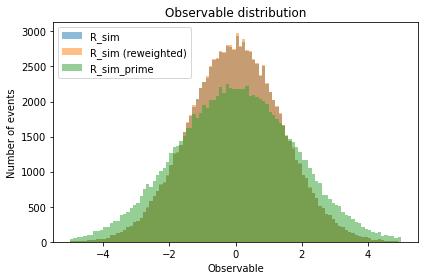

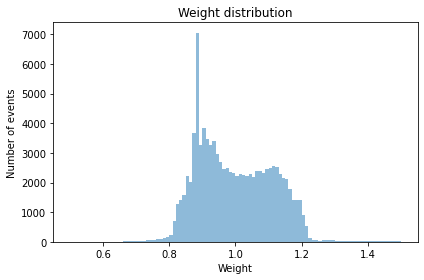

In [60]:
plt.hist(R_sim, range=(-5, 5), density=False, bins=100, label="R_sim", alpha=0.5)
plt.hist(R_sim, weights=weights, range=(-5, 5), density=False, bins=100, label="R_sim (reweighted)", alpha=0.5)
plt.hist(R_sim_prime, range=(-5, 5), density=False, bins=100, label="R_sim_prime", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(weights, range=(0.5, 1.5), density=False, bins=100, label="R_sim", alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Number of events')
plt.title(r'Weight distribution')
# plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()